In [1]:
# ! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
# Downloading a sample of MNIST containing just 3 and 7s supplied by fastai
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

# Creating the Training Set
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]

stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

# Creating the Validation Set
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()]).float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()]).float()/255

# MNIST Loss Function

All of what we saw in the Stochastic Gradient Descent excercise can be transposed directly to the MNIST dataset, except for the loss function.
Here, we will see how we can define a good training objective.

## Preparing our Training and Validation Sets
We already have our independent variables *x* (the images themselves). So we'll concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). We can do this using ```view```, which is a PyTorch method that changes the shape of a tensor without changing its contents. ```-1``` is a special parameter to ```view``` that means "make this axis as big as necessary to fit all the data".

In [4]:
# Squishing our training data into a single tensor
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

We need a label for each image, so let's use `1` for 3s and `0` for 7s.

In [5]:
# Generating labels for each image
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

A ```Dataset``` in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality.

In [6]:
dataset = list(zip(train_x, train_y))

# Grabbing an image from the dataset and displaying its shape
x,y = dataset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

We will need to perform the same steps for the validation set.

In [7]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dataset = list(zip(valid_x, valid_y))

## Step 1: Initialise the Parameters
We need an (initially random) weight for every pixel.

In [8]:
def init_params(size, var=1.0): return (torch.randn(size)*var).requires_grad_()

In [9]:
# Initialising random weights
weights = init_params((28*28,1))

The function `weights*pixels` won't be flexible enough - it is always equal to 0 when the pixels are equal to 0.
Remembering from linear algebra that the formula for a line is `y=w*x + b`, we still need the `b`.

We'll initialise it to a random number too.

In [10]:
# Initialising random bias
bias = init_params(1)

In neural networks, the `w` in the equation `y=w*x+b` is called the *weights* and the `b` is called the *bias*. Together, the weights and bias make up the *parameters*.

## Step 2: Calculate Predictions
Let's first calculate a prediction for one image.

In [11]:
# Generating a single prediction
(train_x[0]*weights.T).sum() + bias

tensor([-6.2330], grad_fn=<AddBackward0>)

While we could use a Python `for` loop to calculate the prediction for each image, that would be very slow.

In this case, we can use *matrix multiplication* which calculates `w*x` for every row of a matrix.

In Python, matrix multiplication is represented with the `@` operator.

In [12]:
# Function to calculate predictions using matrix multiplication
def linear1(xb): return xb @ weights + bias

In [13]:
# Generating predictions for all images in the dataset
preds = linear1(train_x)
preds

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

The first element is the same as what we calculated before, as expected.

This equation `batch@weights + bias` is one of the two fundamental equations of any neural network (the other one is the *activation function*)

## Step 3: Calculate the Loss
To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0.0, so our accuracy for each item can be calculated (using broadcasting).

In [14]:
# Calculating Accuracy
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [15]:
# Mean Accuracy
corrects.float().mean().item()

0.5379961133003235

Now let's see what the change in accuracy is for a small change in one of the weights.

NOTE: We have to ask PyTorch not to calculate gradients as we do this, which is what `with torch.no_grad()` is doing here.

In [16]:
with torch.no_grad(): weights[0] *= 1.0001
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5379961133003235

As we've seen before, we need gradients in order to improve our model using SGD, and in order to calculate gradients we need some *loss* function that represents how good our model is. That is because the gradients are a measure of how that loss function changes with small tweaks to the weights.

So how do we choose a loss function? The obvious approach would be to use accuracy, which is our metric, as our loss function as well. In this case, we would calculate our prediction for each image, collect these values to calculate an overall accuracy, and then calculate the gradients of each weight with respect to that overall accuracy.

Unfortunately, we have a significant technical problem here. The gradient of a function is its slope and is mathematically represented by `(y_new - y_old) / (x_new - x_old)`. As accuracy only changes at when a prediction changes from a 3 to a 7 or vice versa, a small change in weights from `x_old` to `x_new` isn't likely to cause any prediction change, so `(y_new - y_old)` will always be 0.
In other words, the gradient is 0 almost everywhere. This means it is not useful to use accuracy as a loss function - if we do, most of the time our gradients will actually be 0 and the model will not be able to learn from that number.


Instead, we need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss. Let's write such a function. What form does it take?

The loss function receives not the images themselves, but the predictions from the model. Let's make one argument, `prds`, of values between 0 and 1, where each value is the prediction that an image is a 3. It is a vector (i.e., a rank-1 tensor), indexed over the images.

The purpose of the loss function is the measure the difference between the predicted values and the true values - that is, the targets (aka labels). Let's make another argument, `trgts`, with values of 0 or 1 which tells wehther an image actually is a 3 or not. It is also a vector (i.e., another rank-1 tensor), indexed over the images.

So, for instance, supposed we had three images which we knew were a 3, a 7, and a 3. And suppose our model predicted with high confidence `(0.9)` that the first was a 3, with a slight confidence `(0.4)` that the second was a 7, and with fair confidence `(0.2)`, but incorrectly, that the last was a 7. This would mean our loss function would received the following values as its inputs.

In [17]:
trgts = tensor([1,0,1])
prds = tensor([0.9, 0.4, 0.2])

Here is a first try at a loss function that measures the distance between `predictions` and `targets`.

In [18]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

This function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.

Let's try it on our `prds` and `trgts`.

In [19]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

We can see that the function returns a lower number when predictions are more accurate. In PyTorch, we always assume that a lower value of loss function is better. 

Since we need a scalar for the final loss, `mnist_loss` takes the mean of the previous tensor.

In [20]:
mnist_loss(prds, trgts)

tensor(0.4333)

One problem with `mnist_loss` as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is always the case.

Fortunately, we can achieved this using the `sigmoid` function, which always outputs a number between 0 and 1. It is defined as follows.

In [21]:
def sigmoid(x): return 1/(1+torch.exp(-x))

PyTorch defines an accelerated version of this for us though, so we don't really need our own. This is what it looks like.

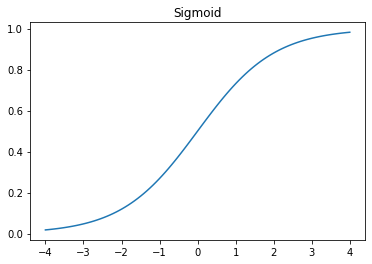

In [22]:
plot_function(torch.sigmoid, title="Sigmoid", min=-4, max=4)

As you can see, it takes any input value, positive or negative, and smooshes it onto an output value between 0 and 1. It's also a smooth curve that only goes up, which makes it easier for SGD to find meaningful gradients.

Let's update `mnist_loss` to first apply `sigmoid` to the inputs.

In [23]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Now we can be confident that our loss function will work, even if the predictions are not between 0 and 1. All that is required is that a higher prediction corrections to a higher confidence an image is a 3.

Having defined a loss function, let's recapitulate why we did this if we already had a metric.
The key difference is that the metric is to drive human understanding and the loss is to drive automated learning. To drive automated learning, the loss must be a function that has a meaningful derivative. It can't have big flat sections and large jumps, but instead must be reasonably smooth. That is why we designed a loss function that would respond to small changes in confidence level. The loss function is calculated for each item in our dataset, and then at the end of an epoch the loss values are all averaged and the overall mean is reported for the epoch.

Metrics on the other hand, are the numbers we really care about. These are the values that are printed at the end of each epoch that tell us how our model is really doing. It is important that we learn to focus on these metrics, rather than the loss, when judging the performance of a model.

## Step 4: Calculate the Gradients

Now that we have our loss function that is suitable for driving SGD, we can consider some of the details involved in the next phase of the learning process, which is to change or update the weights based on gradients. Also called the *optimisation* step.

In order to take an optimisation step, we need to calculate the loss over one or more data items. We could calculated it for the whole dataset, and take the average, or we could calculate it for a single item. Calculating it for the whole dataset would take a very long time. Calculating it for a single item would not use much information, so it would result in a very imprecise and unstable gradient. That is, we'd be going through the trouble of updating the weights, but taking into account only how that would improve the model's performance on that single item.

Instead, we calculate the average loss for a few data items at a time, also known as a *mini-batch*. The number of data items in the mini-batch is called the *batch size*. A larger batch size means that you will get a more accurate and stable estimate of your dataset's gradients from the loss function, but it will take longer, and you will process fewer mini-batches per epoch. Choosing a good batch size is one of the decisions that you need to make to train your model more quickly and accurately.

Another good reason for using mini-batches is that, in practice, we nearly always do our training on an GPU. These only perform well if you have lots of work to do at a time, so it's helpful if we can give them lots of data items to work on. Using mini-batches is one of the best ways to do this, however too many data items can result in them running out of memory.

Recalling our discussion on data augmentation, we can get better generalisation if we can vary things during training. One simple and effective thing we can vary is what data items we put in each mini-batch. Rather than simply enumerating our dataset in order for every epoch, instead what we normally do is randomly shuffle it on every epoch, before we create mini-batches. PyTorch and fastai provide a class that will do the shuffling and mini-batch collation for you, called `DataLoader`.

A `DataLoader` can take any Python collection and turn it into an iterator over mini-batches, like so.

In [24]:
# Creating mini-batches using DataLoader
col1 = range(15)
dl = DataLoader(col1, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

For training a model, we don't just want any Python collection, but a collection containing independent and dependent variables. A collection that contains tuples of independent and dependent variables is known in PyTorch as a `Dataset`.

Here is an example of an extremely simple `Dataset`.

In [25]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

When we pass a `Dataset` to a `DataLoader`, we will get back mini-batches which are themselves tuples of tensors representing batches of independent and dependent variables.

In [26]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

We are now ready to write our first training loop for a model using SGD!.
Our process will be implemented something like this for each epoch.
```
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred,y)
    loss.backward()
    parameters -= parameters.grad * lr
    parameters.grad = None
```

First, let's re-initialise our parameters.

In [27]:
weights = init_params((28*28, 1))
bias = init_params(1)

A `DataLoader` can be created from a `Dataset`.

In [28]:
dl = DataLoader(dataset, batch_size=256)

xb,yb = first(dl)       # Grabs the first batch of data
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

We'll do the same for the Validation Set.

In [29]:
valid_dl = DataLoader(valid_dataset, batch_size=256)

Let's create a mini-batch of size 4 for testing.

In [30]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [31]:
preds = linear1(batch)
preds

tensor([[11.6180],
        [ 9.0489],
        [-2.4524],
        [-2.5197]], grad_fn=<AddBackward0>)

In [32]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.4616, grad_fn=<MeanBackward0>)

Now we can calculate the gradients.

In [33]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0057), tensor([-0.0355]))

Let's put it all in a function and test it.

In [34]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [35]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0113), tensor([-0.0710]))

But what happens it we call it twice?

In [36]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0170), tensor([-0.1065]))

The gradients have changed! The reason for this is that `loss.backward` actually *adds* the gradients of `loss` to any gradients that are currently stored. So we have to set the gradients back to zero first. This can be done using `.grad.zero_()`.

In [37]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

# Step 5: Step the Weights

Our only remaining step is to update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too - otherwise things will get very confusing when we try to compute the derivative at the next batch!. If we assign the `data` attribute of a tensor, then PyTorch will not take the gradient of that step. Our basic training loop for each epoch now becomes the following.

In [38]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

We also want to check how we're doing, by looking at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. So our accuracy for each item can be calculated.


In [39]:
(preds>0.0).float() == train_y[:4]

tensor([[ True],
        [ True],
        [False],
        [False]])

This gives us this function to calculate our validation accuracy.

In [40]:
def batch_accuracy(xb,yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

Let's check that it works.


In [41]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.5000)

Now let's put the batches together.


In [42]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(),4)

In [43]:
validate_epoch(linear1)

0.5484

That's our starting point. Let's train for one epoch, and see if the accuracy improves.

In [44]:
# Training for 1 Epoch
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6293

## Step 6: Repeating the Process

Let's repeat the above proess for 20 epochs.

In [45]:
# Training for 20 Epochs
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8129 0.913 0.9442 0.956 0.9623 0.9667 0.9692 0.9706 0.9721 0.974 0.9745 0.975 0.976 0.9765 0.9765 0.977 0.9775 0.9775 0.9775 0.9775 

After a few epochs, we have reached the same accuracy as the "Pixel Similarity" approach, and we've created a general-purpose foundation we can build on.
Our next step will be to create an object that will handle the SGD step for us. In PyTorch, it's called an optimizer.